# Overview

### `clean_us_data.ipynb`: Fix data inconsistencies in the raw time series data from [`etl_us_data.ipynb`](./etl_us_data.ipynb).

Inputs:
* `outputs/us_counties.csv`: Raw county-level time series data for the United States, produced by running [etl_us_data.ipynb](./etl_us_data.ipynb)
* `outputs/us_counties_meta.json`: Column type metadata for reading `data/us_counties.csv` with `pd.read_csv()`

Outputs:
* `outputs/us_counties_clean.csv`: The contents of `outputs/us_counties.csv` after data cleaning
* `outputs/us_counties_clean_meta.json`: Column type metadata for reading `data/us_counties_clean.csv` with `pd.read_csv()`
* `outputs/us_counties_clean.feather`: Binary version of `us_counties_clean.csv`, in [Feather](https://arrow.apache.org/docs/python/feather.html) format.
* `outputs/dates.feather`: Dates associated with points in time series, in [Feather](https://arrow.apache.org/docs/python/feather.html) format.

**Note:** You can redirect these input and output files by setting the environment variables `COVID_INPUTS_DIR` and `COVID_OUTPUTS_DIR` to replacement values for the prefixes `inputs` and `outputs`, respectively, in the above paths.

# Read and reformat the raw data

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# Allow environment variables to override data file locations.
_INPUTS_DIR = os.getenv("COVID_INPUTS_DIR", "inputs")
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

## Read the CSV file from `etl_us_data.ipynb` and apply the saved type information

In [2]:
csv_file = os.path.join(_OUTPUTS_DIR, "us_counties.csv")
meta_file = os.path.join(_OUTPUTS_DIR, "us_counties_meta.json")

# Read column type metadata
with open(meta_file) as f:
    cases_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
cases_meta["Date"] = "object"

cases_raw = pd.read_csv(csv_file, dtype=cases_meta, parse_dates=["Date"])

# Restore the Pandas index
cases_vertical = cases_raw.set_index(["FIPS", "Date"], verify_integrity=True)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2022-02-16  Wyoming   Weston        6927       1530      17          0   
      2022-02-17  Wyoming   Weston        6927       1531      17          0   
      2022-02-18  Wyoming   Weston        6927       1532      17          0   
      2022-02-19  Wyoming   Weston        6927       1532      17          0   
      2022-02-20  Wyoming   Weston        6927       1532      17          0   

                  Confirmed_NYT  Deaths_NYT  Confirmed_USAFacts  \
FIPS  Date                                                        
1001  2020-01-22           <NA>        <NA>                   0   
      2020-01-23           <NA>        <NA>                   0   
      2020-01-24           <NA>        <NA>                   0   
      2020-01-25           <NA>        <NA>                   0   
      2020-01-26           <NA>        <NA>                   0   
...                         ...         ...                 ...   
56045 2022-02-16           1530          17                <NA>   
      2022-02-17           1531          17                <NA>   
      2022-02-18           1532          17                <NA>   
      2022-02-19           1532          17                <NA>   
      2022-02-20           1532          17                <NA>   

                  Deaths_USAFacts  
FIPS  Date                         
1001  2020-01-22                0  
      2020-01-23                0  
      2020-01-24                0  
      2020-01-25                0  
      2020-01-26                0  
...                           ...  
56045 2022-02-16             <NA>  
      2022-02-17             <NA>  
      2022-02-18             <NA>  
      2022-02-19             <NA>  
      2022-02-20             <NA>  

[2392584 rows x 10 columns]

## Replace missing values in the secondary datasets with zeros

In [3]:
for colname in ("Confirmed_NYT", "Deaths_NYT", "Confirmed_USAFacts", "Deaths_USAFacts"):
    cases_vertical[colname].fillna(0, inplace=True)
    cases_vertical[colname] = cases_vertical[colname].astype("int64")

cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2022-02-16  Wyoming   Weston        6927       1530      17          0   
      2022-02-17  Wyoming   Weston        6927       1531      17          0   
      2022-02-18  Wyoming   Weston        6927       1532      17          0   
      2022-02-19  Wyoming   Weston        6927       1532      17          0   
      2022-02-20  Wyoming   Weston        6927       1532      17          0   

                  Confirmed_NYT  Deaths_NYT  Confirmed_USAFacts  \
FIPS  Date                                                        
1001  2020-01-22              0           0                   0   
      2020-01-23              0           0                   0   
      2020-01-24              0           0                   0   
      2020-01-25              0           0                   0   
      2020-01-26              0           0                   0   
...                         ...         ...                 ...   
56045 2022-02-16           1530          17                   0   
      2022-02-17           1531          17                   0   
      2022-02-18           1532          17                   0   
      2022-02-19           1532          17                   0   
      2022-02-20           1532          17                   0   

                  Deaths_USAFacts  
FIPS  Date                         
1001  2020-01-22                0  
      2020-01-23                0  
      2020-01-24                0  
      2020-01-25                0  
      2020-01-26                0  
...                           ...  
56045 2022-02-16                0  
      2022-02-17                0  
      2022-02-18                0  
      2022-02-19                0  
      2022-02-20                0  

[2392584 rows x 10 columns]

## Collapse each time series down to a single cell

This kind of time series data is easier to manipulate at the macroscopic level if each time series occupies a 
single cell of the DataFrame. We use the [TensorArray](https://text-extensions-for-pandas.readthedocs.io/en/latest/#text_extensions_for_pandas.TensorArray) Pandas extension type from [Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas).

In [4]:
cases, dates = util.collapse_time_series(cases_vertical, ["Confirmed", "Deaths", "Recovered", 
                                                          "Confirmed_NYT", "Deaths_NYT",
                                                          "Confirmed_USAFacts", "Deaths_USAFacts"])
cases

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_NYT,Deaths_NYT,Confirmed_USAFacts,Deaths_USAFacts
FIPS,,,,,,,,,,
1001,Alabama,Autauga,55869,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1003,Alabama,Baldwin,223234,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1005,Alabama,Barbour,24686,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1007,Alabama,Bibb,22394,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1009,Alabama,Blount,57826,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
56039,Wyoming,Teton,23464,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
56041,Wyoming,Uinta,20226,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
# Note that the previous cell also saved the values from the "Date"
# column of `cases_vertical` into the Python variable `dates`:
dates[:10], dates.shape

(array(['2020-01-22T00:00:00.000000000', '2020-01-23T00:00:00.000000000',
        '2020-01-24T00:00:00.000000000', '2020-01-25T00:00:00.000000000',
        '2020-01-26T00:00:00.000000000', '2020-01-27T00:00:00.000000000',
        '2020-01-28T00:00:00.000000000', '2020-01-29T00:00:00.000000000',
        '2020-01-30T00:00:00.000000000', '2020-01-31T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 (761,))

In [6]:
# Print out the time series for the Bronx as a sanity check
bronx_fips = 36005
cases.loc[bronx_fips]["Confirmed"]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      1,
            5,      5,      7,     10,     20,     28,     57,     86,
          209,    363,    554,    851,   1218,   1824,   2279,   2890,
         3728,   4557,   5403,   6304,   6962,   7766,  10134,  11463,
        12761,  14018,  15350,  16832,  17882,  18737,  20289,  21793,
        23135,  24453,  25720,  26754,  27553,  28276,  29389,  30488,
        31463,  32399,  32974,  33526,  34529,  35188,  36131,  36880,
        37474,  37897,  38103,  38663,  39340,  39904,  40392,  40847,
        41116,  41274,  41629,  41925,  42213,  42515,  42772,  42947,
      

# Correct for missing data for today in USAFacts data

The USAFacts database only receives the previous day's updates late in the day,
so it's often missing the last value. Substitute the previous day's value if
that is the case.

In [7]:
# Last 10 days of the time series for the Bronx before this change
cases.loc[bronx_fips]["Deaths_USAFacts"].to_numpy()[-10:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
# last element <-- max(last element, second to last)
new_confirmed = cases["Confirmed_USAFacts"].to_numpy().copy()
new_confirmed[:, -1] = np.maximum(new_confirmed[:, -1], new_confirmed[:, -2])
cases["Confirmed_USAFacts"] = tp.TensorArray(new_confirmed)

new_deaths = cases["Deaths_USAFacts"].to_numpy().copy()
new_deaths[:, -1] = np.maximum(new_deaths[:, -1], new_deaths[:, -2])
cases["Deaths_USAFacts"] = tp.TensorArray(new_deaths)

# Last 10 days of the time series for the Bronx after this change
cases.loc[bronx_fips]["Deaths_USAFacts"].to_numpy()[-10:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Validate the New York City confirmed cases data

Older versions of the Johns Hopkins data coded all of New York city as being
in New York County. Each borough is actually in a different county
with a different FIPS code.

Verify that this problem hasn't recurred.

In [9]:
max_bronx_confirmed = np.max(cases.loc[36005]["Confirmed"])
if max_bronx_confirmed == 0:
    raise ValueError(f"Time series for the Bronx is all zeros again:\n{cases.loc[36005]['Confirmed']}")

In [10]:
max_bronx_confirmed

403410

Also plot the New York City confirmed cases time series to allow for manual validation.

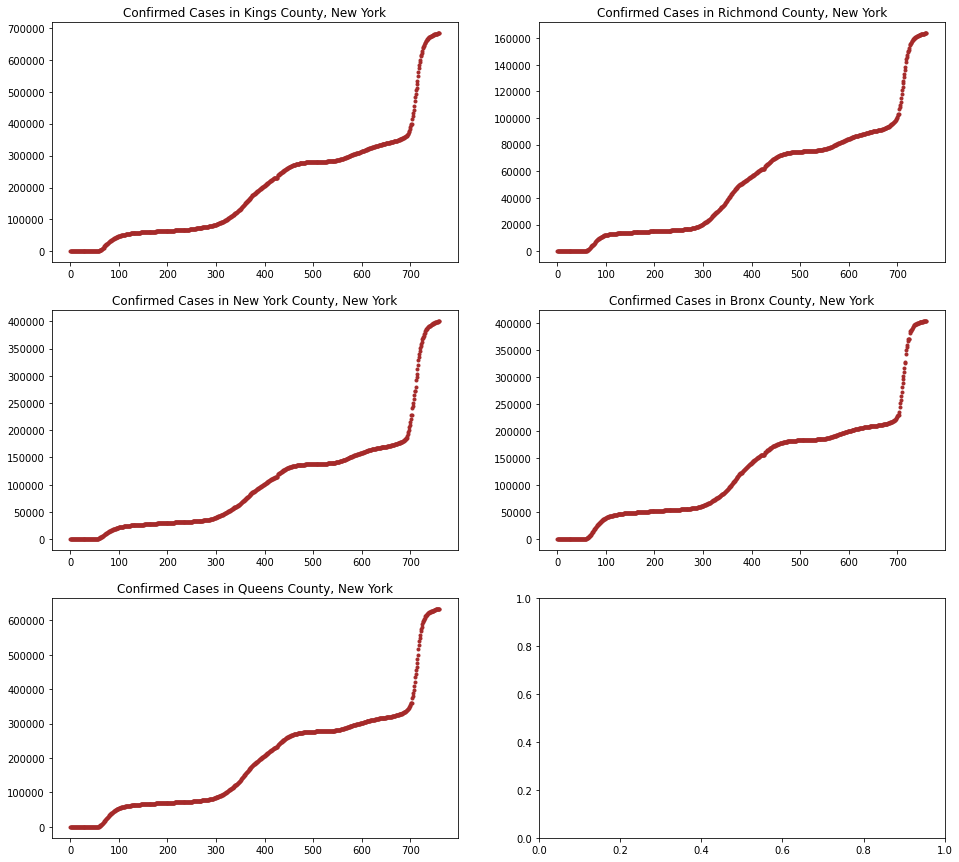

In [11]:
new_york_county_fips = 36061
nyc_fips = [
    36005,  # Bronx County
    36047,  # Kings County
    new_york_county_fips,  # New York County
    36081,  # Queens County
    36085,  # Richmond County
]
util.graph_examples(cases.loc[nyc_fips], "Confirmed", {}, num_to_pick=5)

## Adjust New York City deaths data

Plot deaths for New York City in the Johns Hopkins data set. The jump in June is due to a change in reporting.

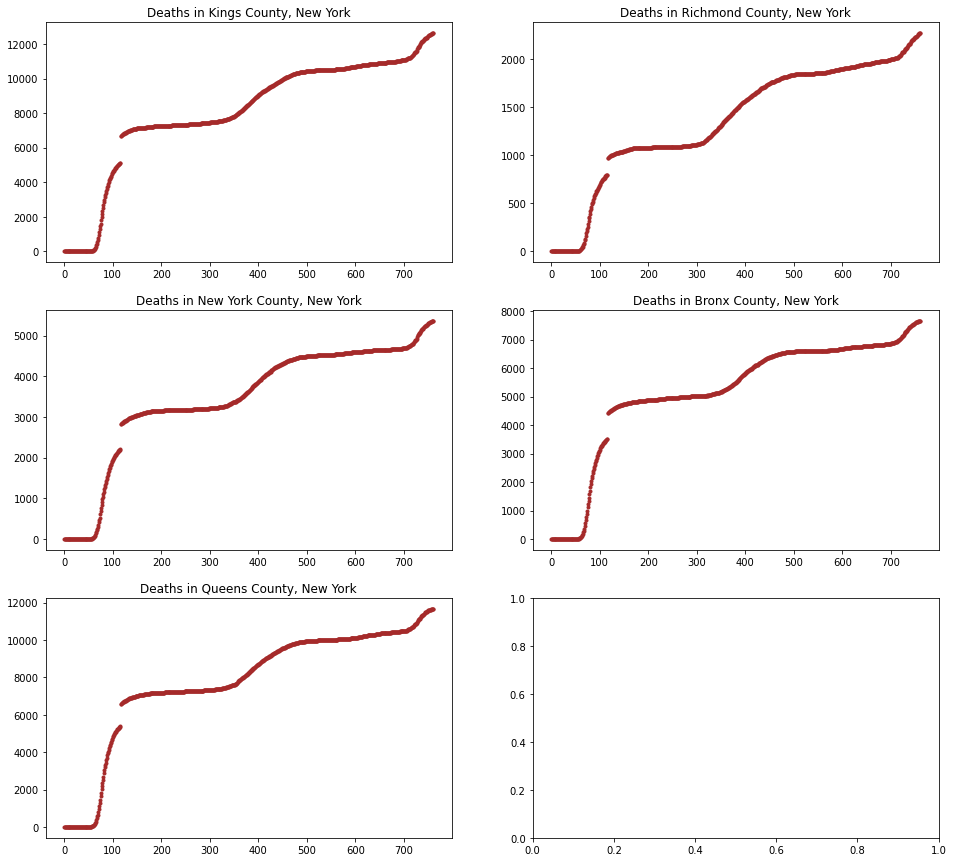

In [12]:
util.graph_examples(cases.loc[nyc_fips], "Deaths", {}, num_to_pick=5)

New York Times version of the time series for deaths in New York city:

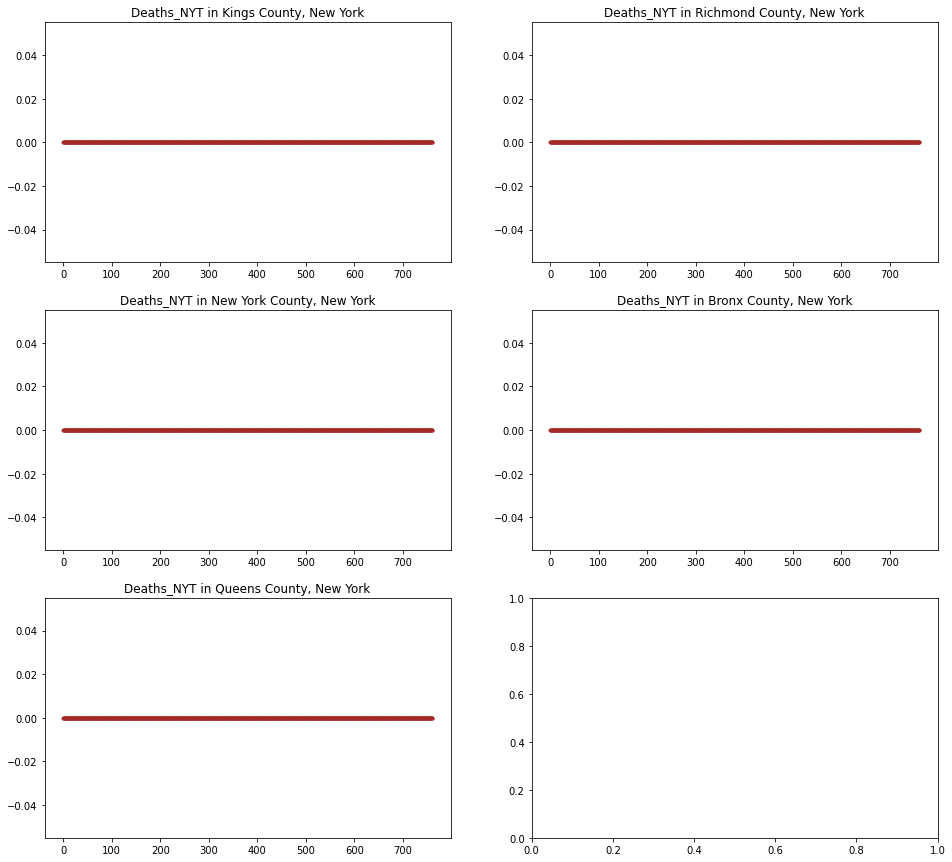

In [13]:
util.graph_examples(cases.loc[nyc_fips], "Deaths_NYT", {}, num_to_pick=5)

USAFacts version of the time series for deaths in New York city:

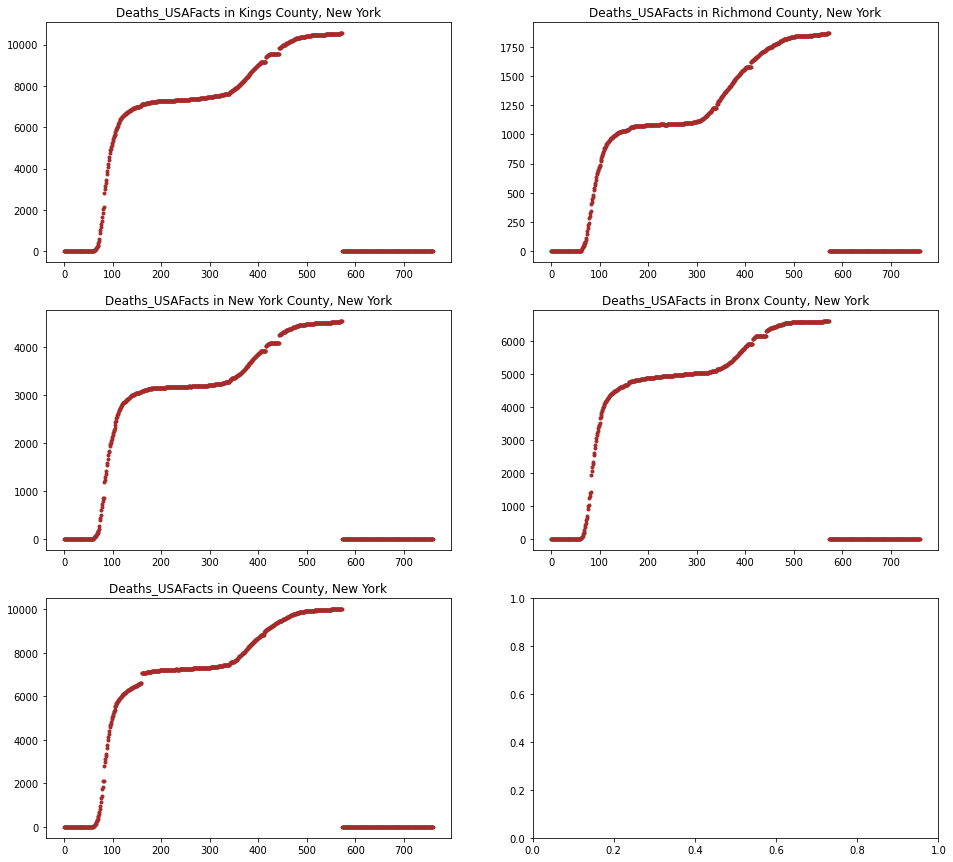

In [14]:
util.graph_examples(cases.loc[nyc_fips], "Deaths_USAFacts", {}, num_to_pick=5)

Currently the USAFacts version is cleanest, so we use that one.

After:


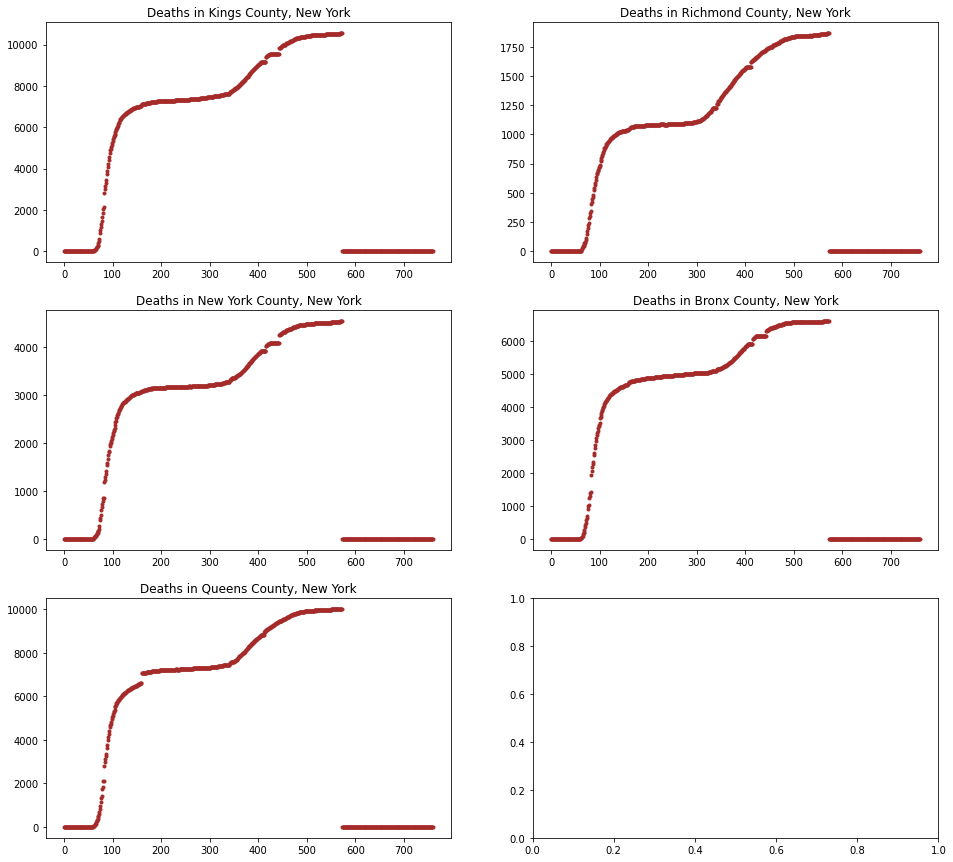

In [15]:
new_deaths = cases["Deaths"].copy(deep=True)
for fips in nyc_fips:
    new_deaths.loc[fips] = cases["Deaths_USAFacts"].loc[fips]
cases["Deaths"] = new_deaths 

print("After:")
util.graph_examples(cases.loc[nyc_fips], "Deaths", {}, num_to_pick=5)

# Clean up the Rhode Island data

The Johns Hopkins data reports zero deaths in most of Rhode Island. Use 
the secondary data set from the New York Times for Rhode Island.

Before:


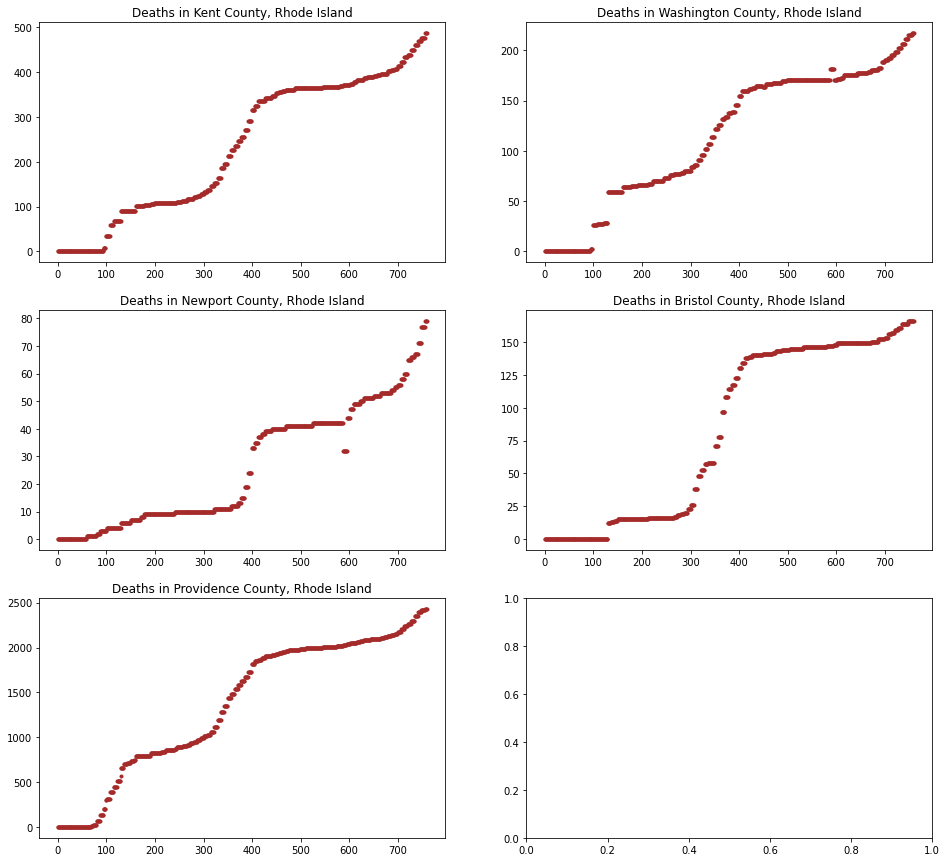

In [16]:
print("Before:")
util.graph_examples(cases, "Deaths", {}, num_to_pick=8, 
                    mask=(cases["State"] == "Rhode Island"))

After:


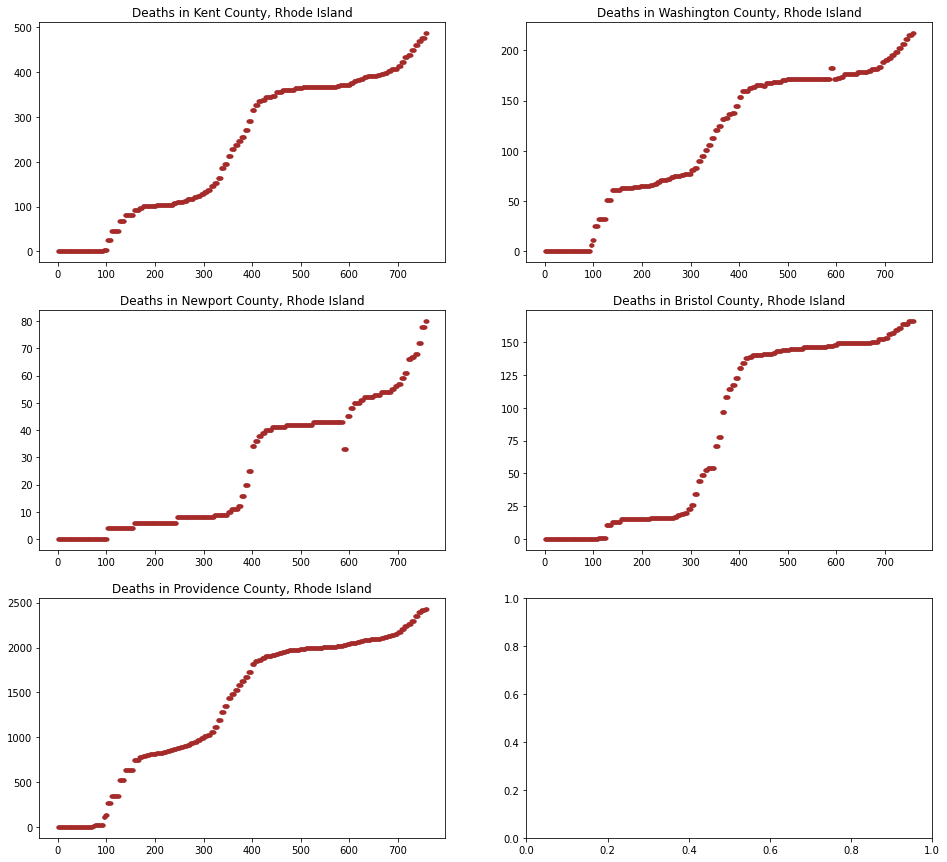

In [17]:
# Use our secondary data set for all Rhode Island data.
ri_fips = cases[cases["State"] == "Rhode Island"].index.values.tolist()
for colname in ["Confirmed", "Deaths"]:
    new_series = cases[colname].copy(deep=True)
    for fips in ri_fips:
        new_series.loc[fips] = cases[colname + "_NYT"].loc[fips]
    cases[colname] = new_series 

# Note that the secondary data set has not "Recovered" time series, so
# we leave those numbers alone for now.

print("After:")
util.graph_examples(cases, "Deaths", {}, num_to_pick=8, 
                    mask=(cases["State"] == "Rhode Island"))

# Clean up the Utah data

The Johns Hopkins data for Utah is missing quite a few data points.
Use the New York Times data for Utah.

Before:


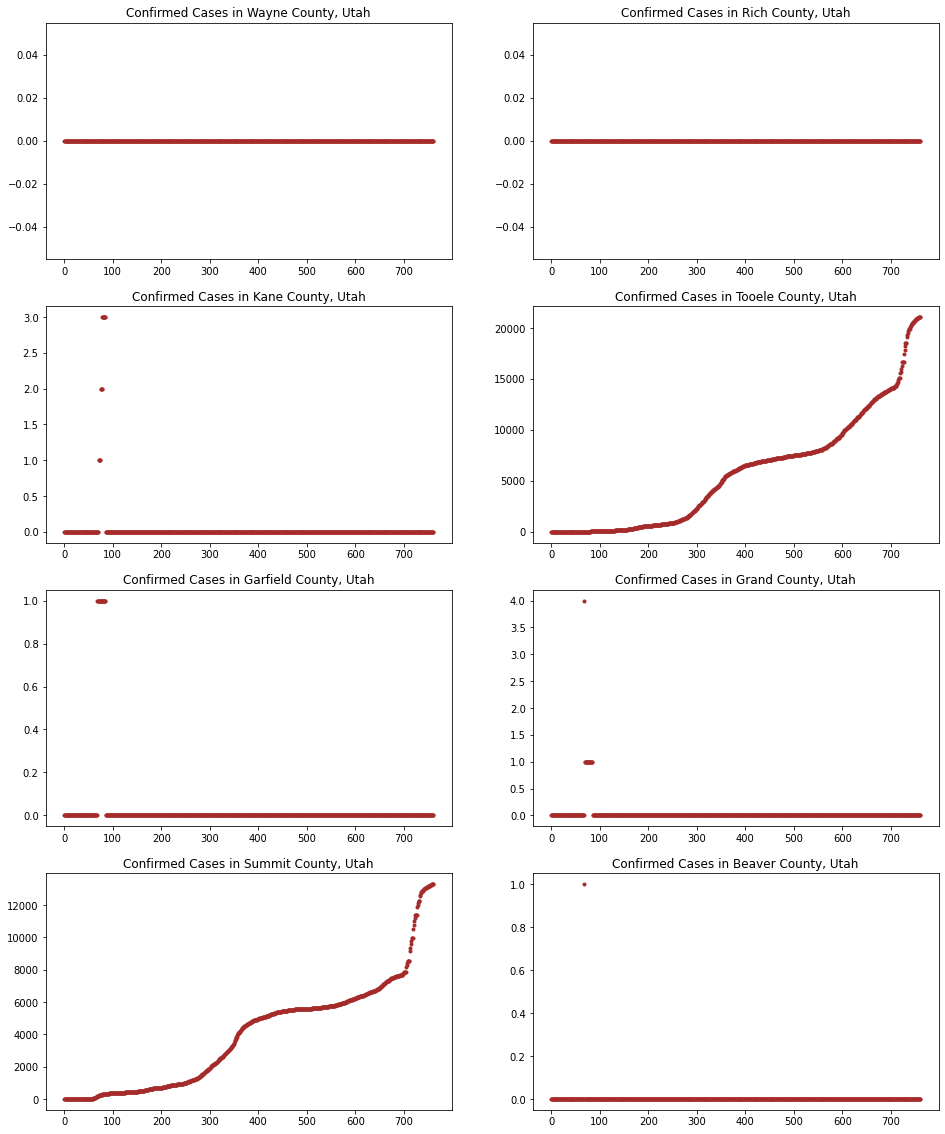

In [18]:
print("Before:")
util.graph_examples(cases, "Confirmed", {}, num_to_pick=8, 
                    mask=(cases["State"] == "Utah"))

After:


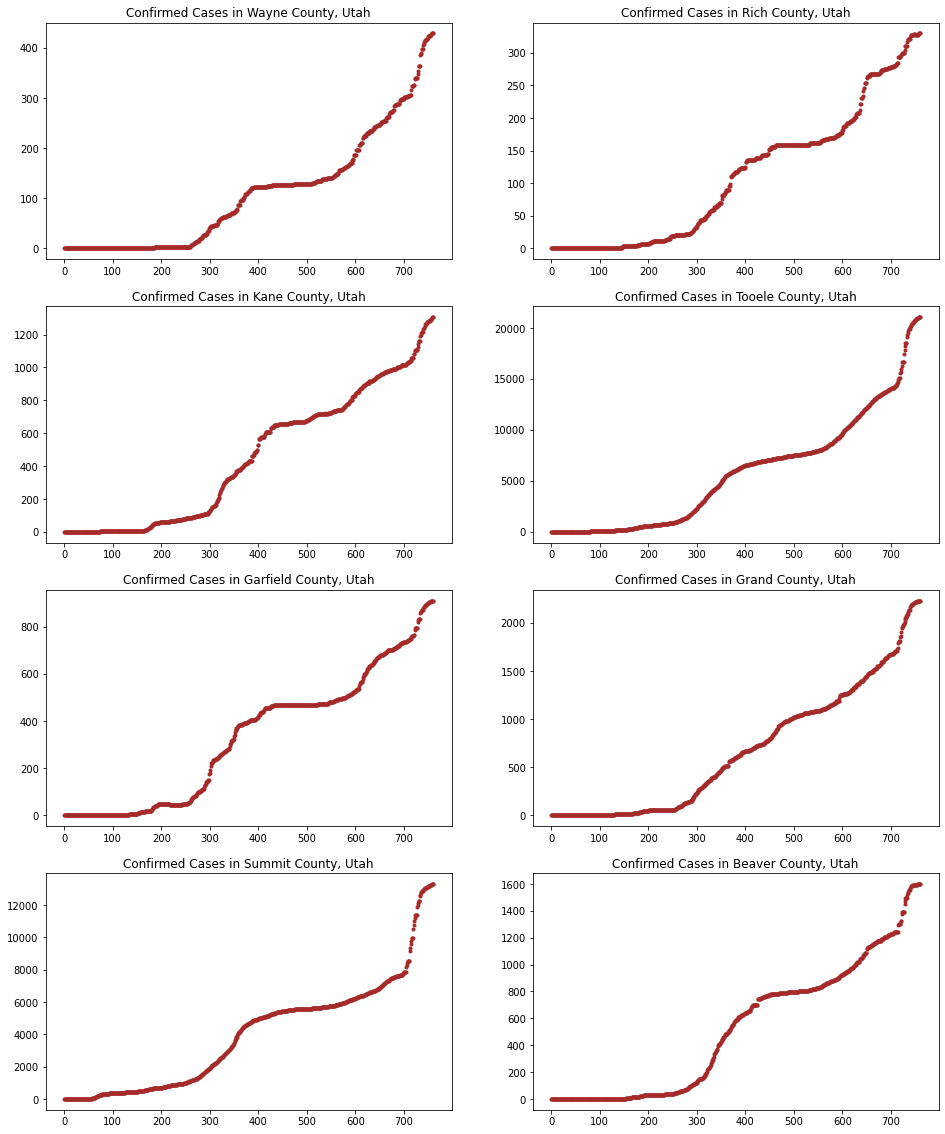

In [19]:
# The Utah time series from the New York Times' data set are more 
# complete, so we use those numbers.
ut_fips = cases[cases["State"] == "Utah"].index.values
for colname in ["Confirmed", "Deaths"]:
    new_series = cases[colname].copy(deep=True)
    for fips in ut_fips:
        new_series.loc[fips] = cases[colname + "_NYT"].loc[fips]
    cases[colname] = new_series 

# Note that the secondary data set has not "Recovered" time series, so
# we leave those numbers alone for now.

print("After:")
util.graph_examples(cases, "Confirmed", {}, num_to_pick=8, 
                    mask=(cases["State"] == "Utah"))

# Flag additional problematic and missing data points

Use heuristics to identify and flag problematic data points across all 
the time series. Generate Boolean masks that show the locations of these
outliers.

In [20]:
# Now we're done with the secondary data set, so drop its columns.
cases = cases.drop(columns=["Confirmed_NYT", "Deaths_NYT", "Confirmed_USAFacts", "Deaths_USAFacts"])
cases

,State,County,Population,Confirmed,Deaths,Recovered
FIPS,,,,,,
1001,Alabama,Autauga,55869,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1003,Alabama,Baldwin,223234,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1005,Alabama,Barbour,24686,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1007,Alabama,Bibb,22394,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1009,Alabama,Blount,57826,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
56039,Wyoming,Teton,23464,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
56041,Wyoming,Uinta,20226,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [21]:
# Now we need to find and flag obvious data-entry errors.
# We'll start by creating columns of "is outlier" masks.
# We use integers instead of Boolean values as a workaround for
# https://github.com/pandas-dev/pandas/issues/33770

# Start out with everything initialized to "not an outlier"
cases["Confirmed_Outlier"] = tp.TensorArray(np.zeros_like(cases["Confirmed"].values))
cases["Deaths_Outlier"] = tp.TensorArray(np.zeros_like(cases["Deaths"].values))
cases["Recovered_Outlier"] = tp.TensorArray(np.zeros_like(cases["Recovered"].values))

cases

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1003,Alabama,Baldwin,223234,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1005,Alabama,Barbour,24686,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1007,Alabama,Bibb,22394,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1009,Alabama,Blount,57826,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
56039,Wyoming,Teton,23464,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
56041,Wyoming,Uinta,20226,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Flag time series that go from zero to nonzero and back again

One type of anomaly that occurs fairly often involves a time series
jumping from zero to a nonzero value, then back to zero again.

Locate all instances of that pattern and mark the nonzero values
as outliers.

In [22]:
def nonzero_then_zero(series: np.array):
    empty_mask = np.zeros_like(series, dtype=np.int8)
    if series[0] > 0:
        # Special case: first value is nonzero
        return empty_mask
    first_nonzero_offset = 0
    while first_nonzero_offset < len(series):
        if series[first_nonzero_offset] > 0:
            # Found the first nonzero.
            # Find the distance to the next zero value.
            next_zero_offset = first_nonzero_offset + 1
            while (next_zero_offset < len(series)
                   and series[next_zero_offset] > 0):
                next_zero_offset += 1
            
            # Check the length of the run of zeros after
            # dropping back to zero.
            second_nonzero_offset = next_zero_offset + 1
            while (second_nonzero_offset < len(series)
                   and series[second_nonzero_offset] == 0):
                second_nonzero_offset += 1
                
            nonzero_run_len = next_zero_offset - first_nonzero_offset
            second_zero_run_len = second_nonzero_offset - next_zero_offset
            
            # print(f"{first_nonzero_offset} -> {next_zero_offset} -> {second_nonzero_offset}; series len {len(series)}")
            if next_zero_offset >= len(series):
                # Everything after the first nonzero was a nonzero
                return empty_mask
            elif second_zero_run_len <= nonzero_run_len:
                # Series dropped back to zero, but the second zero
                # part was shorter than the nonzero section.
                # In this case, it's more likely that the second run
                # of zero values are actually missing values.
                return empty_mask
            else:
                # Series went zero -> nonzero -> zero -> nonzero
                # or zero -> nonzero -> zero -> [end]
                nonzero_run_mask = empty_mask.copy()
                nonzero_run_mask[first_nonzero_offset:next_zero_offset] = 1  
                return nonzero_run_mask
        first_nonzero_offset += 1   
    # If we get here, the series was all zeros
    return empty_mask
    
for colname in ["Confirmed", "Deaths", "Recovered"]:
    addl_outliers = np.stack([nonzero_then_zero(s.to_numpy()) for s in cases[colname]])
    outliers_colname = colname + "_Outlier"
    new_outliers = cases[outliers_colname].values.astype(bool) | addl_outliers
    cases[outliers_colname] = tp.TensorArray(new_outliers.astype(np.int8))

# fips = 13297
# print(cases.loc[fips]["Confirmed"])
# print(nonzero_then_zero(cases.loc[fips]["Confirmed"]))

In [23]:
# Let's have a look at which time series acquired the most outliers as 
# a result of the code in the previous cell.
df = cases[["State", "County"]].copy()
df["Confirmed_Num_Outliers"] = np.count_nonzero(cases["Confirmed_Outlier"], axis=1)
counties_with_outliers = df.sort_values("Confirmed_Num_Outliers", ascending=False).head(10)
counties_with_outliers

,State,County,Confirmed_Num_Outliers
FIPS,,,
6069,California,San Benito,12
15005,Hawaii,Kalawao,11
29215,Missouri,Texas,10
48395,Texas,Robertson,9
27149,Minnesota,Stevens,9
48031,Texas,Blanco,9
48145,Texas,Falls,9
32017,Nevada,Lincoln,8
46041,South Dakota,Dewey,8


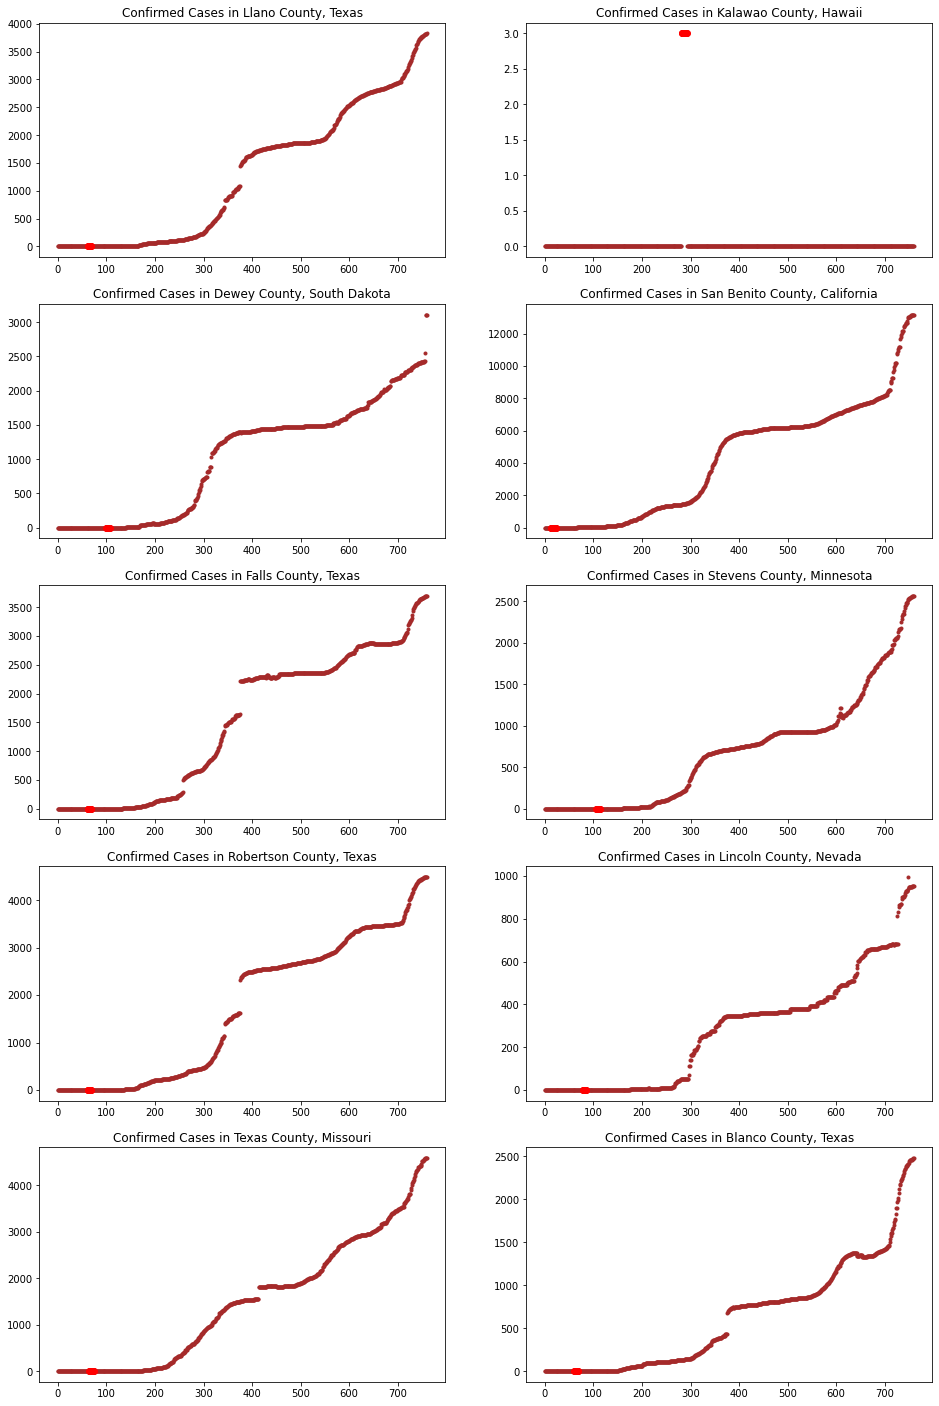

In [24]:
# Plot the couties in the table above, with outliers highlighted.
# The graph_examples() function is defined in util.py.
util.graph_examples(cases, "Confirmed", {}, num_to_pick=10, mask=(cases.index.isin(counties_with_outliers.index)))

## Flag time series that drop to zero, then go back up

Another type of anomaly involves the time series dropping down to 
zero, then going up again. Since all three time series are supposed
to be cumulative counts, this pattern most likely indicates missing
data.

To correct for this problem, we mark any zero values after the
first nonzero, non-outlier values as outliers, across all time series.

In [25]:
def zeros_after_first_nonzero(series: np.array, outliers: np.array):
    nonzero_mask = (series != 0)
    nonzero_and_not_outlier = nonzero_mask & (~outliers)
    first_nonzero = np.argmax(nonzero_and_not_outlier)
    if 0 == first_nonzero and series[0] == 0:
        # np.argmax(nonzero_mask) will return 0 if there are no nonzeros
        return np.zeros_like(series)
    after_nonzero_mask = np.zeros_like(series)
    after_nonzero_mask[first_nonzero:] = True
    return (~nonzero_mask) & after_nonzero_mask

for colname in ["Confirmed", "Deaths", "Recovered"]:
    outliers_colname = colname + "_Outlier"
    addl_outliers = np.stack([zeros_after_first_nonzero(s.to_numpy(), o.to_numpy()) 
                              for s, o in zip(cases[colname], cases[outliers_colname])])
    new_outliers = cases[outliers_colname].values.astype(np.bool) | addl_outliers
    cases[outliers_colname] = tp.TensorArray(new_outliers.astype(np.int8))

# fips = 47039
# print(cases.loc[fips]["Confirmed"])
# print(cases.loc[fips]["Confirmed_Outlier"])
# print(zeros_after_first_nonzero(cases.loc[fips]["Confirmed"], cases.loc[fips]["Confirmed_Outlier"]))   

/var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26459/1086722740.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new_outliers = cases[outliers_colname].values.astype(np.bool) | addl_outliers


In [26]:
# Redo our "top 10 by number of outliers" analysis with the additional outliers
df = cases[["State", "County"]].copy()
df["Confirmed_Num_Outliers"] = np.count_nonzero(cases["Confirmed_Outlier"], axis=1)
counties_with_outliers = df.sort_values("Confirmed_Num_Outliers", ascending=False).head(10)
counties_with_outliers

,State,County,Confirmed_Num_Outliers
FIPS,,,
31103,Nebraska,Keya Paha,65
20003,Kansas,Anderson,27
16061,Idaho,Lewis,26
40149,Oklahoma,Washita,17
51600,Virginia,Fairfax City,13
6069,California,San Benito,12
15005,Hawaii,Kalawao,11
29215,Missouri,Texas,10
46041,South Dakota,Dewey,10


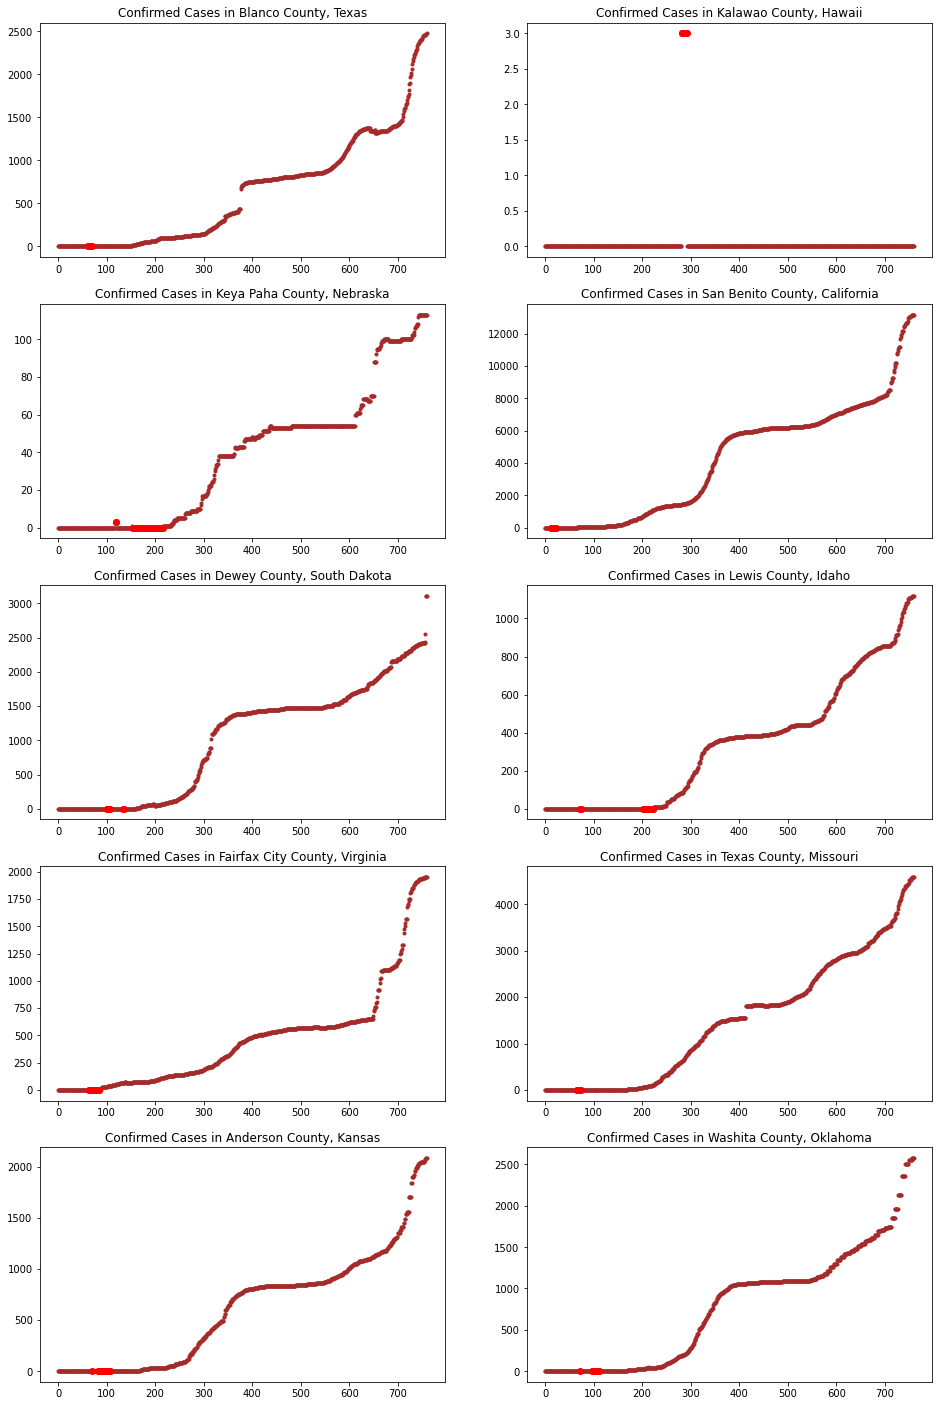

In [27]:
util.graph_examples(cases, "Confirmed", {}, num_to_pick=10, mask=(cases.index.isin(counties_with_outliers.index)))

In [28]:
# The steps we've just done have removed quite a few questionable
# data points, but you will definitely want to flag additional 
# outliers by hand before trusting descriptive statistics about
# any county.

# TODO: Incorporate manual whitelists and blacklists of outliers
#  into this notebook.

# Precompute totals for the last 7 days

Several of the notebooks downstream of this one need the number of cases and deaths
for the last 7 days, so we compute those values here for convenience.

In [29]:
def last_week_results(s: pd.Series):
    arr = s.to_numpy()
    today = arr[:,-1]
    week_ago = arr[:,-8]
    return today - week_ago

cases["Confirmed_7_Days"] = last_week_results(cases["Confirmed"])
cases["Deaths_7_Days"] = last_week_results(cases["Deaths"])
cases.head()

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier,Confirmed_7_Days,Deaths_7_Days
FIPS,,,,,,,,,,,
1001,Alabama,Autauga,55869,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",124,8
1003,Alabama,Baldwin,223234,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",319,9
1005,Alabama,Barbour,24686,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20,3
1007,Alabama,Bibb,22394,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,2
1009,Alabama,Blount,57826,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",116,3


# Write out cleaned time series data

By default, output files go to the `outputs` directory. You can use the `COVID_OUTPUTS_DIR` environment variable to override that location.

## CSV output

Comma separated value (CSV) files are a portable text-base format supported by a wide variety
of different tools. The CSV format does not include type information, so we write a second
file of schema data in JSON format.

In [30]:
# Break out our time series into multiple rows again for writing to disk.
cleaned_cases_vertical = util.explode_time_series(cases, dates)
cleaned_cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2022-02-16  Wyoming   Weston        6927       1530      17          0   
      2022-02-17  Wyoming   Weston        6927       1531      17          0   
      2022-02-18  Wyoming   Weston        6927       1532      17          0   
      2022-02-19  Wyoming   Weston        6927       1532      17          0   
      2022-02-20  Wyoming   Weston        6927       1532      17          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  \
FIPS  Date                                                               
1001  2020-01-22                  0               0                  0   
      2020-01-23                  0               0                  0   
      2020-01-24                  0               0                  0   
      2020-01-25                  0               0                  0   
      2020-01-26                  0               0                  0   
...                             ...             ...                ...   
56045 2022-02-16                  0               0                  0   
      2022-02-17                  0               0                  0   
      2022-02-18                  0               0                  0   
      2022-02-19                  0               0                  0   
      2022-02-20                  0               0                  0   

                  Confirmed_7_Days  Deaths_7_Days  
FIPS  Date                                         
1001  2020-01-22               124              8  
      2020-01-23               124              8  
      2020-01-24               124              8  
      2020-01-25               124              8  
      2020-01-26               124              8  
...                            ...            ...  
56045 2022-02-16                 8              0  
      2022-02-17                 8              0  
      2022-02-18                 8              0  
      2022-02-19                 8              0  
      2022-02-20                 8              0  

[2392584 rows x 11 columns]

In [31]:
# The outlier masks are stored as integers as a workaround for a Pandas
# bug. Convert them to Boolean values for writing to disk.
cleaned_cases_vertical["Confirmed_Outlier"] = cleaned_cases_vertical["Confirmed_Outlier"].astype(np.bool)
cleaned_cases_vertical["Deaths_Outlier"] = cleaned_cases_vertical["Deaths_Outlier"].astype(np.bool)
cleaned_cases_vertical["Recovered_Outlier"] = cleaned_cases_vertical["Recovered_Outlier"].astype(np.bool)
cleaned_cases_vertical

/var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26459/241943460.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cleaned_cases_vertical["Confirmed_Outlier"] = cleaned_cases_vertical["Confirmed_Outlier"].astype(np.bool)
/var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26459/241943460.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2022-02-16  Wyoming   Weston        6927       1530      17          0   
      2022-02-17  Wyoming   Weston        6927       1531      17          0   
      2022-02-18  Wyoming   Weston        6927       1532      17          0   
      2022-02-19  Wyoming   Weston        6927       1532      17          0   
      2022-02-20  Wyoming   Weston        6927       1532      17          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  \
FIPS  Date                                                               
1001  2020-01-22              False           False              False   
      2020-01-23              False           False              False   
      2020-01-24              False           False              False   
      2020-01-25              False           False              False   
      2020-01-26              False           False              False   
...                             ...             ...                ...   
56045 2022-02-16              False           False              False   
      2022-02-17              False           False              False   
      2022-02-18              False           False              False   
      2022-02-19              False           False              False   
      2022-02-20              False           False              False   

                  Confirmed_7_Days  Deaths_7_Days  
FIPS  Date                                         
1001  2020-01-22               124              8  
      2020-01-23               124              8  
      2020-01-24               124              8  
      2020-01-25               124              8  
      2020-01-26               124              8  
...                            ...            ...  
56045 2022-02-16                 8              0  
      2022-02-17                 8              0  
      2022-02-18                 8              0  
      2022-02-19                 8              0  
      2022-02-20                 8              0  

[2392584 rows x 11 columns]

In [32]:
# Write out the results to a CSV file plus a JSON file of type metadata.
cleaned_cases_vertical_csv_data_file = os.path.join(_OUTPUTS_DIR,"us_counties_clean.csv")
print(f"Writing cleaned data to {cleaned_cases_vertical_csv_data_file}")
cleaned_cases_vertical.to_csv(cleaned_cases_vertical_csv_data_file, index=True)
col_type_mapping = {
    key: str(value) for key, value in cleaned_cases_vertical.dtypes.iteritems()
}

cleaned_cases_vertical_json_data_file = os.path.join(_OUTPUTS_DIR,"us_counties_clean_meta.json")
print(f"Writing metadata to {cleaned_cases_vertical_json_data_file}")
with open(cleaned_cases_vertical_json_data_file, "w") as f:
    json.dump(col_type_mapping, f)

Writing cleaned data to outputs/us_counties_clean.csv


Writing metadata to outputs/us_counties_clean_meta.json


## Feather output

The [Feather](https://arrow.apache.org/docs/python/feather.html) file format supports
fast binary I/O over any data that can be represented using [Apache Arrow](https://arrow.apache.org/)
Feather files also include schema and type information.

In [33]:
# Also write out the nested data in Feather format so that downstream
# notebooks don't have to re-nest it.
# No Feather serialization support for Pandas indices currently, so convert
# the index on FIPS code to a normal column
cases_for_feather = cases.reset_index()
cases_for_feather.head()

,FIPS,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier,Confirmed_7_Days,Deaths_7_Days
0,1001,Alabama,Autauga,55869,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",124,8
1,1003,Alabama,Baldwin,223234,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",319,9
2,1005,Alabama,Barbour,24686,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20,3
3,1007,Alabama,Bibb,22394,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,2
4,1009,Alabama,Blount,57826,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",116,3


In [34]:
# Write to Feather and make sure that reading back works too.
# Also write dates that go with the time series
dates_file = os.path.join(_OUTPUTS_DIR, "dates.feather")
cases_file = os.path.join(_OUTPUTS_DIR, "us_counties_clean.feather")
pd.DataFrame({"date": dates}).to_feather(dates_file)
cases_for_feather.to_feather(cases_file)
pd.read_feather(cases_file).head()

,FIPS,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier,Confirmed_7_Days,Deaths_7_Days
0,1001,Alabama,Autauga,55869,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",124,8
1,1003,Alabama,Baldwin,223234,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",319,9
2,1005,Alabama,Barbour,24686,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20,3
3,1007,Alabama,Bibb,22394,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,2
4,1009,Alabama,Blount,57826,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",116,3


In [35]:
# Also make sure the dates can be read back in from a binary file
pd.read_feather(dates_file).head()

,date
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26
